Importowanie Bibliotek

In [2]:
# Common
import tensorflow as tf
from glob import glob
import numpy as np

# Data
from sklearn.model_selection import train_test_split


# Data visualization
import matplotlib.pyplot as plt

# Model
from keras.models import Model
from keras.layers import Input, Conv2D, MaxPooling2D, Conv2DTranspose, concatenate
from keras.optimizers import Adam

# Metrics
from tensorflow.keras.metrics import *
import pathlib
import os
import cv2
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split
from keras.models import load_model
from keras.optimizers import Adam

Wczytanie danych

In [3]:
images = []
masks = []


img_dir = r"C:\Users\Brodzio\OneDrive - Opolska eSzkola\Pulpit\AOM_Projekt\zdjecia\obrazy\PATIENT_DICOM"
folders = sorted([os.path.join(img_dir, filename) for filename in os.listdir(img_dir)])

for folder_path in folders:
    # Sprawdzenie czy element jest folderem
    if os.path.isdir(folder_path):
        # Iteracja po plikach w folderze
        files = sorted([os.path.join(folder_path, filename) for filename in os.listdir(folder_path)])
        for file_path in files:
            img = cv2.imread(file_path, 0)  # Wczytywanie obrazu w skali szarości
            img = img / 255.0  # Normalizacja wartości pikseli do zakresu 0-1
            img = cv2.resize(img, (256, 256))  # Zmiana rozmiaru obrazu na 256x256 pikseli
            img = img.reshape((256, 256, 1))  # Dodanie wymiaru osi do obrazu
            images.append(img)


masks_dir = r"C:\Users\Brodzio\OneDrive - Opolska eSzkola\Pulpit\AOM_Projekt\zdjecia\maski\liver"   
folders = sorted([os.path.join(masks_dir, filename) for filename in os.listdir(masks_dir)]) 
# Wczytywanie masek
for folder_path in folders:
    # Sprawdzenie czy element jest folderem
    if os.path.isdir(folder_path):
        # Iteracja po plikach w folderze
        files = sorted([os.path.join(folder_path, filename) for filename in os.listdir(folder_path)])
        for file_path in files:
            mask = cv2.imread(file_path, 0)  # Wczytywanie maski w skali szarości
            mask = mask / 255.0  # Normalizacja wartości pikseli do zakresu 0-1
            mask = cv2.resize(mask, (256, 256))  # Zmiana rozmiaru maski na 256x256 pikseli
            mask = mask.reshape((256, 256, 1))  # Dodanie wymiaru osi do maski
            masks.append(mask)

# Konwertowanie list na tablice numpy
images = np.array(images)
masks = np.array(masks)


Podział na dane uczące i testowe

In [4]:
X_train, X_test, y_train, y_test = train_test_split(images, masks, test_size=0.1)

In [5]:
print('X_train shape:',X_train.shape)
print('y_train shape:',y_train.shape)
print('X_test shape:',X_test.shape)
print('y_test shape:',y_test.shape)

X_train shape: (1699, 256, 256, 1)
y_train shape: (1699, 256, 256, 1)
X_test shape: (189, 256, 256, 1)
y_test shape: (189, 256, 256, 1)


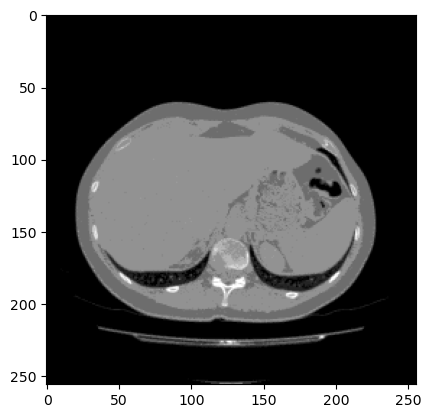

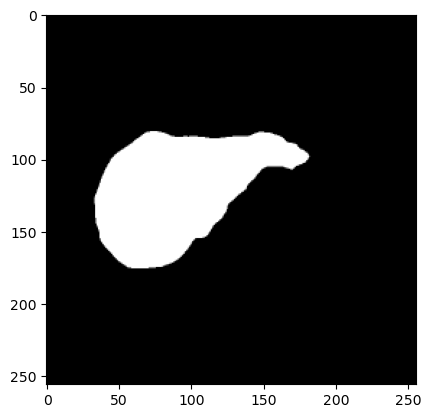

In [6]:
plt.imshow(X_test[7],cmap='gray')
plt.show()
plt.imshow(y_test[7],cmap='gray')
plt.show()

In [7]:
import os  # Importowanie modułu os do operacji na systemie plików
import tensorflow as tf  # Importowanie biblioteki TensorFlow do uczenia maszynowego
import numpy as np  # Importowanie biblioteki NumPy do obliczeń numerycznych
import keras  # Importowanie wysokopoziomowej biblioteki Keras do uczenia maszynowego
import pandas as pd  # Importowanie biblioteki Pandas do manipulacji danymi
import imageio.v2 as imageio  # Importowanie biblioteki imageio do operacji na obrazach
import cv2  # Importowanie biblioteki OpenCV do przetwarzania obrazów
import matplotlib.pyplot as plt  # Importowanie biblioteki Matplotlib do wizualizacji danych
from keras.callbacks import EarlyStopping, ReduceLROnPlateau  # Importowanie funkcji zwrotnej EarlyStopping i ReduceLROnPlateau z Keras
from keras.layers import Conv2DTranspose, BatchNormalization, ReLU, Conv2D, UpSampling2D, MaxPool2D, Dropout  # Importowanie warstw z Keras
from keras import Input, Model  # Importowanie klasy Input i Model z Keras

# Ukrycie pewnych ostrzeżeń z TensorFlow
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

# Definicja funkcji pomocniczej do tworzenia warstw upsamplingu
def create_upsample_layer(filters, kernel_size, padding='same', kernel_initializer='he_normal'):
    """Funkcja tworzy warstwę, która wykonuje upsampling wejściowego tensora za pomocą konwolucji, normalizacji wsadowej i aktywacji ReLU, a następnie upsamplingu."""
    def layer(x):
        x = Conv2D(filters, kernel_size, padding=padding, kernel_initializer=kernel_initializer)(x)
        x = BatchNormalization()(x)
        x = ReLU()(x)
        x = UpSampling2D(size=(2, 2))(x)
        return x
    return layer

# Definicja funkcji pomocniczej do tworzenia warstw downsamplingu
def create_downsample_layer(filters, kernel_size, padding='same', kernel_initializer='he_normal'):
    """Funkcja tworzy warstwę, która wykonuje downsampling wejściowego tensora za pomocą konwolucji, normalizacji wsadowej i aktywacji ReLU, a następnie max pooling."""
    def layer(x):
        x = Conv2D(filters, kernel_size, padding=padding, kernel_initializer=kernel_initializer)(x)
        x = BatchNormalization()(x)
        x = ReLU()(x)
        x = MaxPool2D(pool_size=(2, 2))(x)
        return x
    return layer

# Współczynnik wygaszania
dropout_rate = 0.15

# Definicja warstw modelu DeepUNet
inputs = Input(shape=(256, 256, 1))  # Warstwa wejściowa
x = create_downsample_layer(64, 3, padding='same', kernel_initializer='he_normal')(inputs)  # Encoder - pierwsza warstwa downsamplingu
x = create_downsample_layer(128, 3, padding='same', kernel_initializer='he_normal')(x)  # Encoder - druga warstwa downsamplingu
x = Dropout(dropout_rate)(x)  # Wygaszenie
x = create_downsample_layer(256, 3, padding='same', kernel_initializer='he_normal')(x)  # Encoder - trzecia warstwa downsamplingu
x = Dropout(dropout_rate)(x)  # Wygaszenie
x = create_downsample_layer(512, 3, padding='same', kernel_initializer='he_normal')(x)  # Encoder - czwarta warstwa downsamplingu
x = Dropout(dropout_rate)(x)  # Wygaszenie
x = create_downsample_layer(1024, 3, padding='same', kernel_initializer='he_normal')(x)  # Encoder - piąta warstwa downsamplingu
x = Dropout(dropout_rate)(x)  # Wygaszenie
x = create_downsample_layer(2048, 3, padding='same', kernel_initializer='he_normal')(x)  # Encoder - szósta warstwa downsamplingu
x = Dropout(dropout_rate)(x)  # Wygaszenie

x = create_upsample_layer(1024, 3, padding='same', kernel_initializer='he_normal')(x)  # Decoder - pierwsza warstwa upsamplingu
x = Dropout(dropout_rate)(x)  # Wygaszenie
x = create_upsample_layer(512, 3, padding='same', kernel_initializer='he_normal')(x)  # Decoder - druga warstwa upsamplingu
x = Dropout(dropout_rate)(x)  # Wygaszenie
x = create_upsample_layer(256, 3, padding='same', kernel_initializer='he_normal')(x)  # Decoder - trzecia warstwa upsamplingu
x = Dropout(dropout_rate)(x)  # Wygaszenie
x = create_upsample_layer(128, 3, padding='same', kernel_initializer='he_normal')(x)  # Decoder - czwarta warstwa upsamplingu
x = Dropout(dropout_rate)(x)  # Wygaszenie
x = create_upsample_layer(64, 3, padding='same', kernel_initializer='he_normal')(x)  # Decoder - piąta warstwa upsamplingu
x = Dropout(dropout_rate)(x)  # Wygaszenie
x = create_upsample_layer(32, 3, padding='same', kernel_initializer='he_normal')(x)  # Decoder - szósta warstwa upsamplingu
outputs = Conv2D(1, 1, padding='same', activation='sigmoid')(x)  # Warstwa wyjściowa

# Tworzenie modelu
model = Model(inputs=inputs, outputs=outputs)

In [8]:
# Ustawienie wczesnego zatrzymywania w przypadku braku poprawy na zbiorze walidacyjnym
early_stop = EarlyStopping(
    monitor='val_loss',  # Mierzona metryka: funkcja straty na zbiorze walidacyjnym
    patience=20,  # Maksymalna liczba epok bez poprawy, po której uczenie zostanie zatrzymane
    verbose=1,  # Wyświetlenie komunikatu, gdy zatrzymanie nastąpi
    mode='auto',  # Kierunek poprawy: 'auto' oznacza, że zależy to od metryki monitorowanej ('min' lub 'max')
    restore_best_weights=True  # Przywrócenie wag modelu z epoki, w której uzyskano najlepszy wynik na zbiorze walidacyjnym
)
reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.1,
    patience=10,
    verbose=1, mode='auto'
)

In [9]:
def dice_loss(y_true, y_pred):
    # Spłaszczenie predykcji i ground truth
    y_true_flat = tf.reshape(y_true, [-1])  # Spłaszczenie ground truth do jednego wymiaru
    y_pred_flat = tf.reshape(y_pred, [-1])  # Spłaszczenie predykcji do jednego wymiaru

    # Obliczenie iloczynu przecięcia i sumy
    intersection = tf.reduce_sum(y_true_flat * y_pred_flat)  # Obliczenie iloczynu przecięcia
    union = tf.reduce_sum(y_true_flat) + tf.reduce_sum(y_pred_flat)  # Obliczenie sumy

    # Obliczenie straty Dice'a
    dice_loss = 1 - 2 * intersection / union  # Obliczenie straty Dice'a

    return dice_loss  # Zwrócenie straty Dice'a

# Kompilacja modelu z wykorzystaniem straty Dice'a
model.compile(loss=dice_loss, optimizer='adam', metrics=['accuracy'])

In [10]:
import pandas as pd
# Definicja liczby epok i rozmiaru partii (batch size)
num_epochs = 50  # Liczba epok treningu
batch_size = 16  # Rozmiar partii danych

# Ustawienie ziarna dla generatora liczb losowych TensorFlow
tf.random.set_seed(1)  # Ustawienie ziarna dla powtarzalności wyników

# Trenowanie modelu UNet na danych treningowych
history = model.fit(
    X_train,  # Dane treningowe (obrazy)
    y_train,  # Dane treningowe (maski)
    batch_size=batch_size,  # Rozmiar partii danych używany podczas treningu
    epochs=num_epochs,  # Liczba epok treningu
    callbacks=[early_stop, reduce_lr],  # Funkcje zwrotne używane podczas treningu (wczesne zatrzymywanie i zmniejszenie tempa uczenia)
    validation_data=(X_test, y_test)  # Dane walidacyjne (obrazy i maski)
)
model.save("Unet_model7.h5")
history_df = pd.DataFrame(history.history)
history_df.to_csv('history7.csv', index=False)

Epoch 1/50


107/107 [==============================] - 485s 4s/step - loss: 0.5542 - accuracy: 0.9266 - val_loss: 0.9137 - val_accuracy: 0.9291 - lr: 0.0010
Epoch 2/50
107/107 [==============================] - 457s 4s/step - loss: 0.2787 - accuracy: 0.9746 - val_loss: 0.9740 - val_accuracy: 0.9291 - lr: 0.0010
Epoch 3/50
107/107 [==============================] - 435s 4s/step - loss: 0.1765 - accuracy: 0.9792 - val_loss: 0.9876 - val_accuracy: 0.9291 - lr: 0.0010
Epoch 4/50
107/107 [==============================] - 437s 4s/step - loss: 0.1309 - accuracy: 0.9829 - val_loss: 0.9947 - val_accuracy: 0.9291 - lr: 0.0010
Epoch 5/50
107/107 [==============================] - 434s 4s/step - loss: 0.1089 - accuracy: 0.9850 - val_loss: 0.9859 - val_accuracy: 0.9294 - lr: 0.0010
Epoch 6/50
107/107 [==============================] - 441s 4s/step - loss: 0.1011 - accuracy: 0.9857 - val_loss: 0.6186 - val_accuracy: 0.9454 - lr: 0.0010
Epoch 7/50
107/107 [==============================] - 436s 4s/

C:\Users\Brodzio\AppData\Roaming\Python\Python311\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


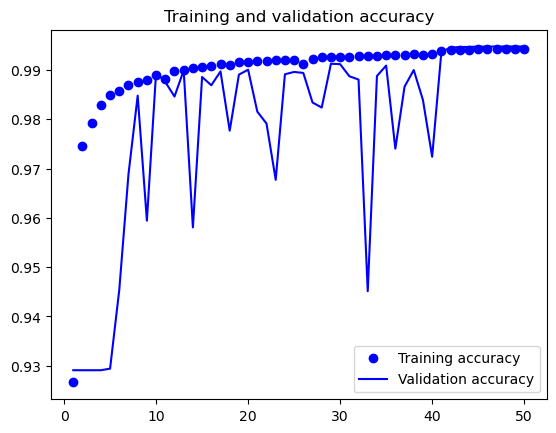

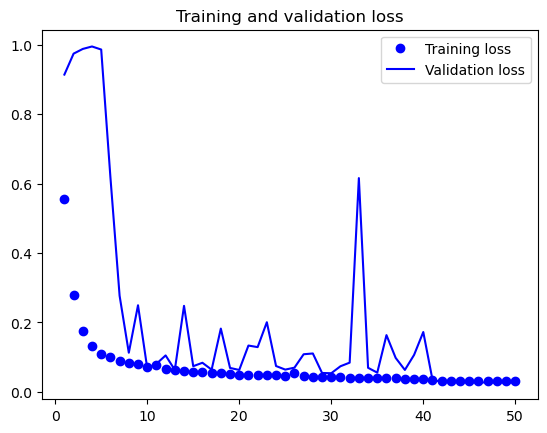

In [11]:
import matplotlib.pyplot as plt

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [12]:
from keras.models import load_model
import cv2
import numpy as np
import matplotlib.pyplot as plt
import os


In [13]:
with keras.utils.custom_object_scope({'dice_loss': dice_loss}):
    model = load_model('Unet_model7.h5')

1/1 [==============================] - 0s 196ms/step


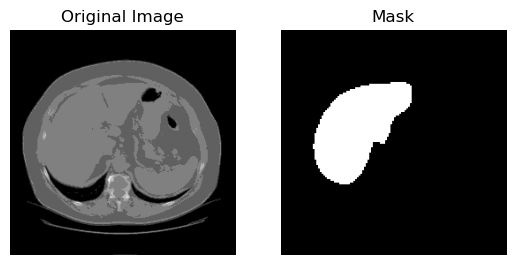

In [35]:
image_dir = r"C:\Users\Brodzio\OneDrive - Opolska eSzkola\Pulpit\AOM_Projekt\zdjecia\obrazy\testowanie\0020"
image = cv2.imread(os.path.join(image_dir, 'IMG00173.png'),0)

image = cv2.resize(image, (256, 256))  # Zmiana rozmiaru obrazu na 256x256 pikseli
image = image / 255.0  # Normalizacja wartości pikseli do zakresu 0-1
image_r = image.reshape(( 1, 256, 256, 1))   # Dodanie wymiaru osi do obrazu


predictions = model.predict(image_r)

# Create mask
threshold = 0.01
mask = np.zeros_like(predictions)
mask[predictions > threshold] = 1

# Display the original image and the mask side by side
fig, axes = plt.subplots(1, 2)
axes[0].imshow(image,cmap='gray')
axes[0].set_title('Original Image')
axes[0].axis('off')
axes[1].imshow(mask[0, :, :, 0], cmap='gray')
axes[1].set_title('Mask')
axes[1].axis('off')
plt.show()